In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt

## Load Dataset and Preprocess

#### transform
ToTensor:  
1) 값이 존재하는 범위를 Z에서 R로  
2) 범위 줄이기 -> gradient(미분계수) 폭발 방지

Normalize: 채널 3개라서 3개씩
    
! num_workers: ?? 메인 프로세스는 학습만, 별도의 프로세스가 다음 배치 미리 읽어옴  
! pin_memory: ?? 데이터를 RAM의 아무데나 넣는게 아니라 고정된 위치에 넣음

In [3]:
IMG_SIZE = 64
BATCH_SIZE = 64

# define trasform
transform = v2.Compose([
    v2.Resize(IMG_SIZE), #1. resize shorter edge into 64
    v2.CenterCrop(IMG_SIZE), #2. crop at the center(rectangle image -> square image)
    v2.ToImage(), #3. (H, W, C) -> (C, H, W)
    v2.ToDtype(torch.float32, scale=True), #4. Z[0, 255] -> R[0.0, 1.0]
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #5. Normalize [0.0, 1.0] -> [-1.0, 1.0]
])

# load data
train_set = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_set = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_set = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

# concaterate into one train dataset
dataset = ConcatDataset([train_set, val_set, test_set])
del train_set, val_set, test_set

# build dataloader
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
)

100%|██████████| 345M/345M [00:20<00:00, 17.2MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.42MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 36.8MB/s]


In [4]:
# Check batch shape
dataloader_iterator = iter(dataloader) # dataloader: iterable -> dataloader_iterator: iterater
sample_batch = next(dataloader_iterator)[0] # bring only features of a batch, not labels
print(f"Shape of Each Batch: {sample_batch.shape}")

Shape of Each Batch: torch.Size([64, 3, 64, 64])


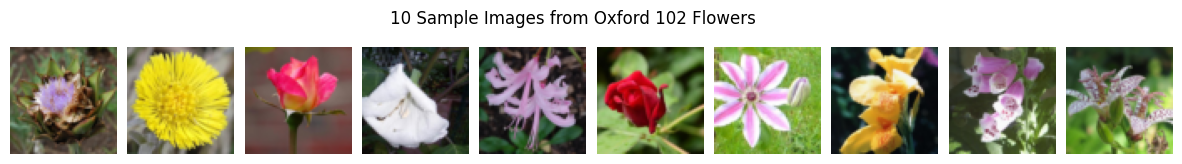

In [5]:
# Visualize 10 sample images
## fetch a single batch for visualization
images = next(dataloader_iterator)[0]

## initialize subplots
fig, axes = plt.subplots(1, 10, figsize=(15, 3)) # fig: top-level container, # axes: numpy array of each grid
plt.subplots_adjust(wspace=0.1)

## plot each subplots
for i in range(10):
  img = images[i]
  img = (img * 0.5) + 0.5 # unnormalize to [0, 1] for visualization
  img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
  axes[i].imshow(img.cpu().numpy()) # display image
  axes[i].axis('off')

plt.suptitle("10 Sample Images from Oxford 102 Flowers", y=0.8)
plt.show()

## Diffusion Schedule (Forward Process)
일단 Linear만 하고 나중에 Cosine이랑 Offset Cosine 추가

sig_rates^2 + nos_rates^2 = 1

In [6]:
def linear_diffusion_schedule(T=1000):
  # beta rates
  min_beta = 0.0001
  max_beta = 0.02

  # betas, alphas, alpha_bars
  betas = torch.linspace(min_beta, max_beta, T)
  alphas = 1 - betas
  alpha_bars = torch.cumprod(alphas, dim=0)

  # signal rates, noise rates
  signal_rates = torch.sqrt(alpha_bars)
  noise_rates = torch.sqrt(1 - alpha_bars)

  return signal_rates, noise_rates # shape: torch.Size([1000])

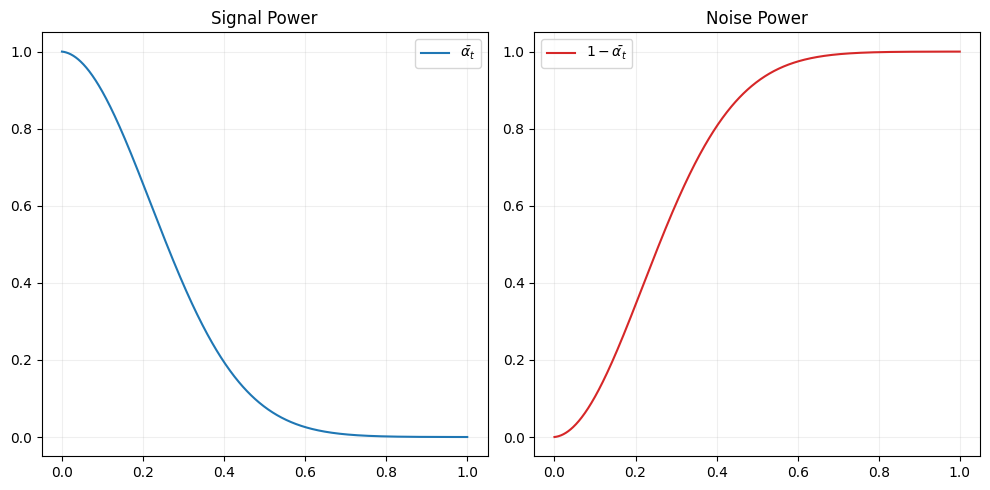

In [7]:
# visualize signal power & noise power
timesteps = torch.linspace(0, 1, 1000)
sig_rates, nos_rates = linear_diffusion_schedule()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

## plot signal power
axes[0].plot(timesteps, sig_rates**2, color="tab:blue", label=r"$\bar{\alpha_t}$")
axes[0].legend()
axes[0].set_title("Signal Power")
axes[0].grid(True, alpha=0.2)

## plot noise power
axes[1].plot(timesteps, nos_rates**2, color="tab:red", label=r"$1-\bar{\alpha_t}$")
axes[1].legend()
axes[1].set_title("Noise Power")
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

## Model

### Sinusoidal Embedding

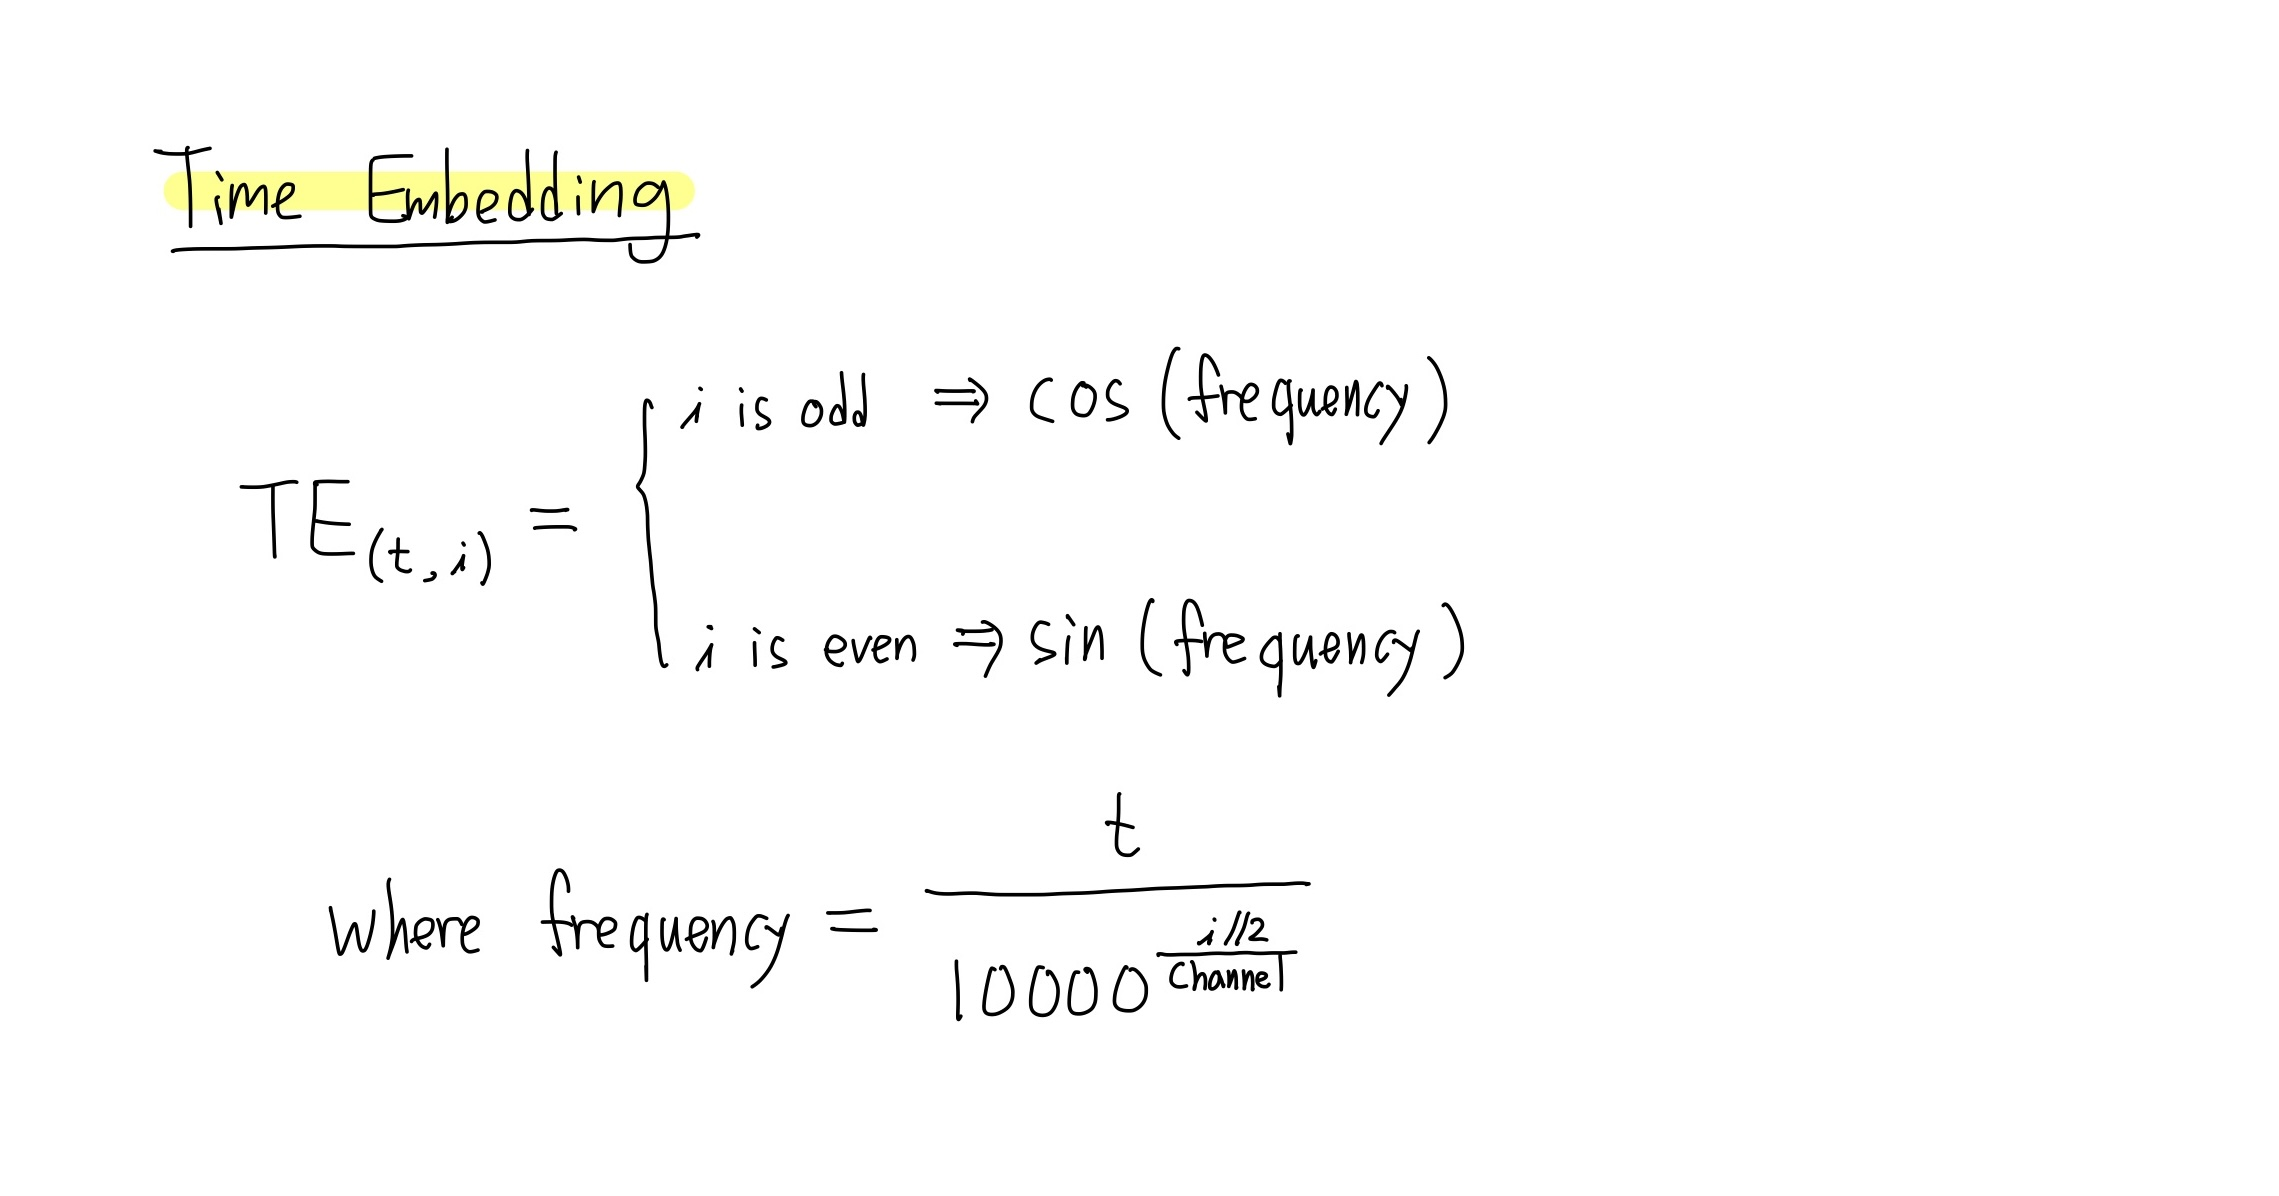

### Residual Block

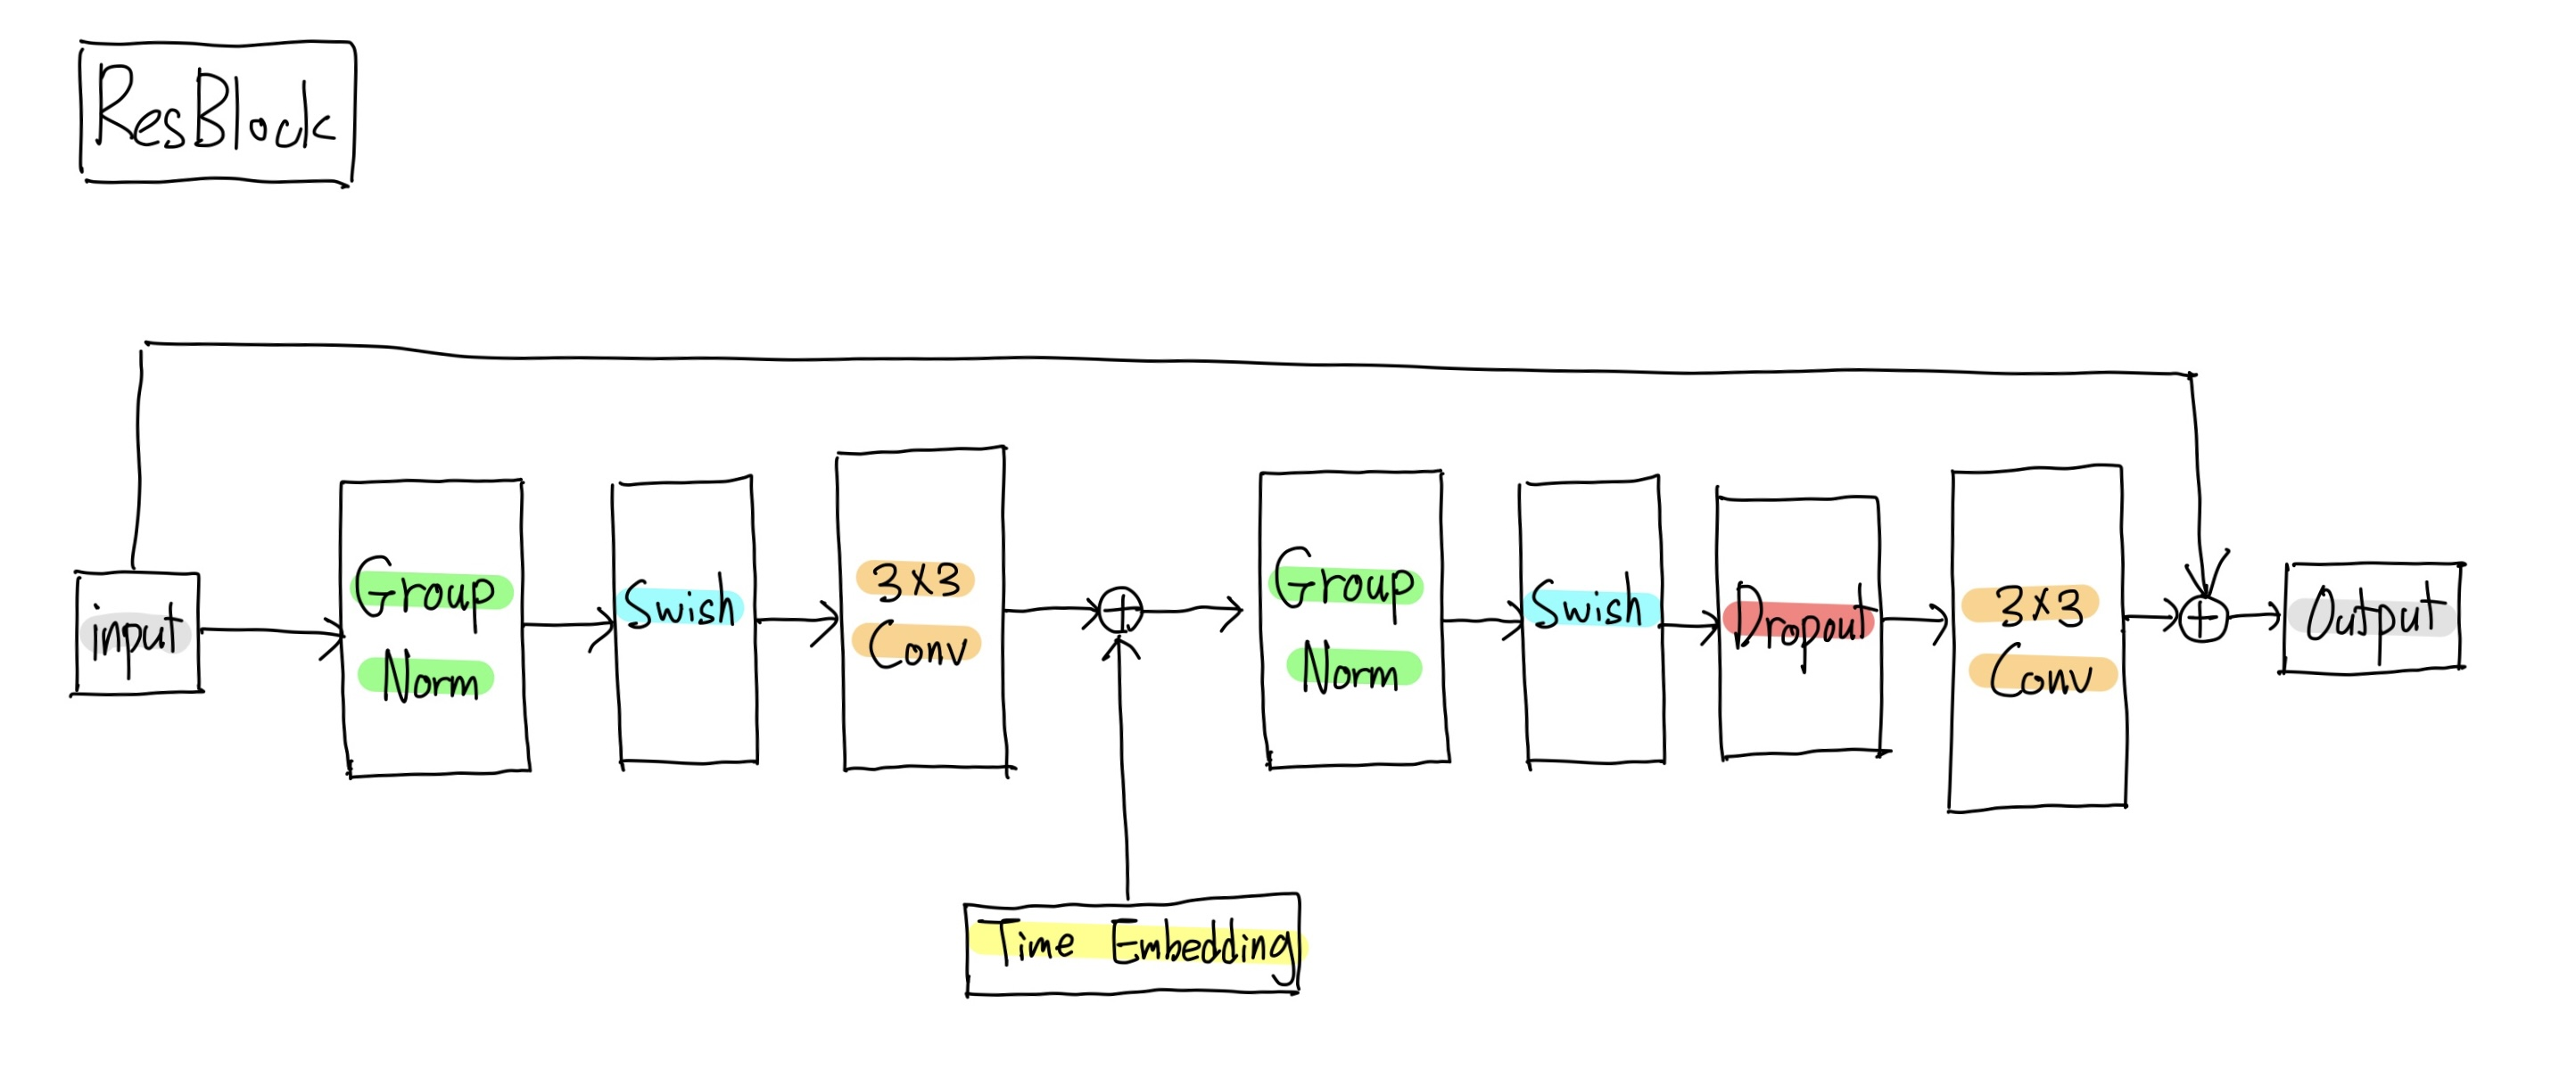

### DownSampling & UpSampling

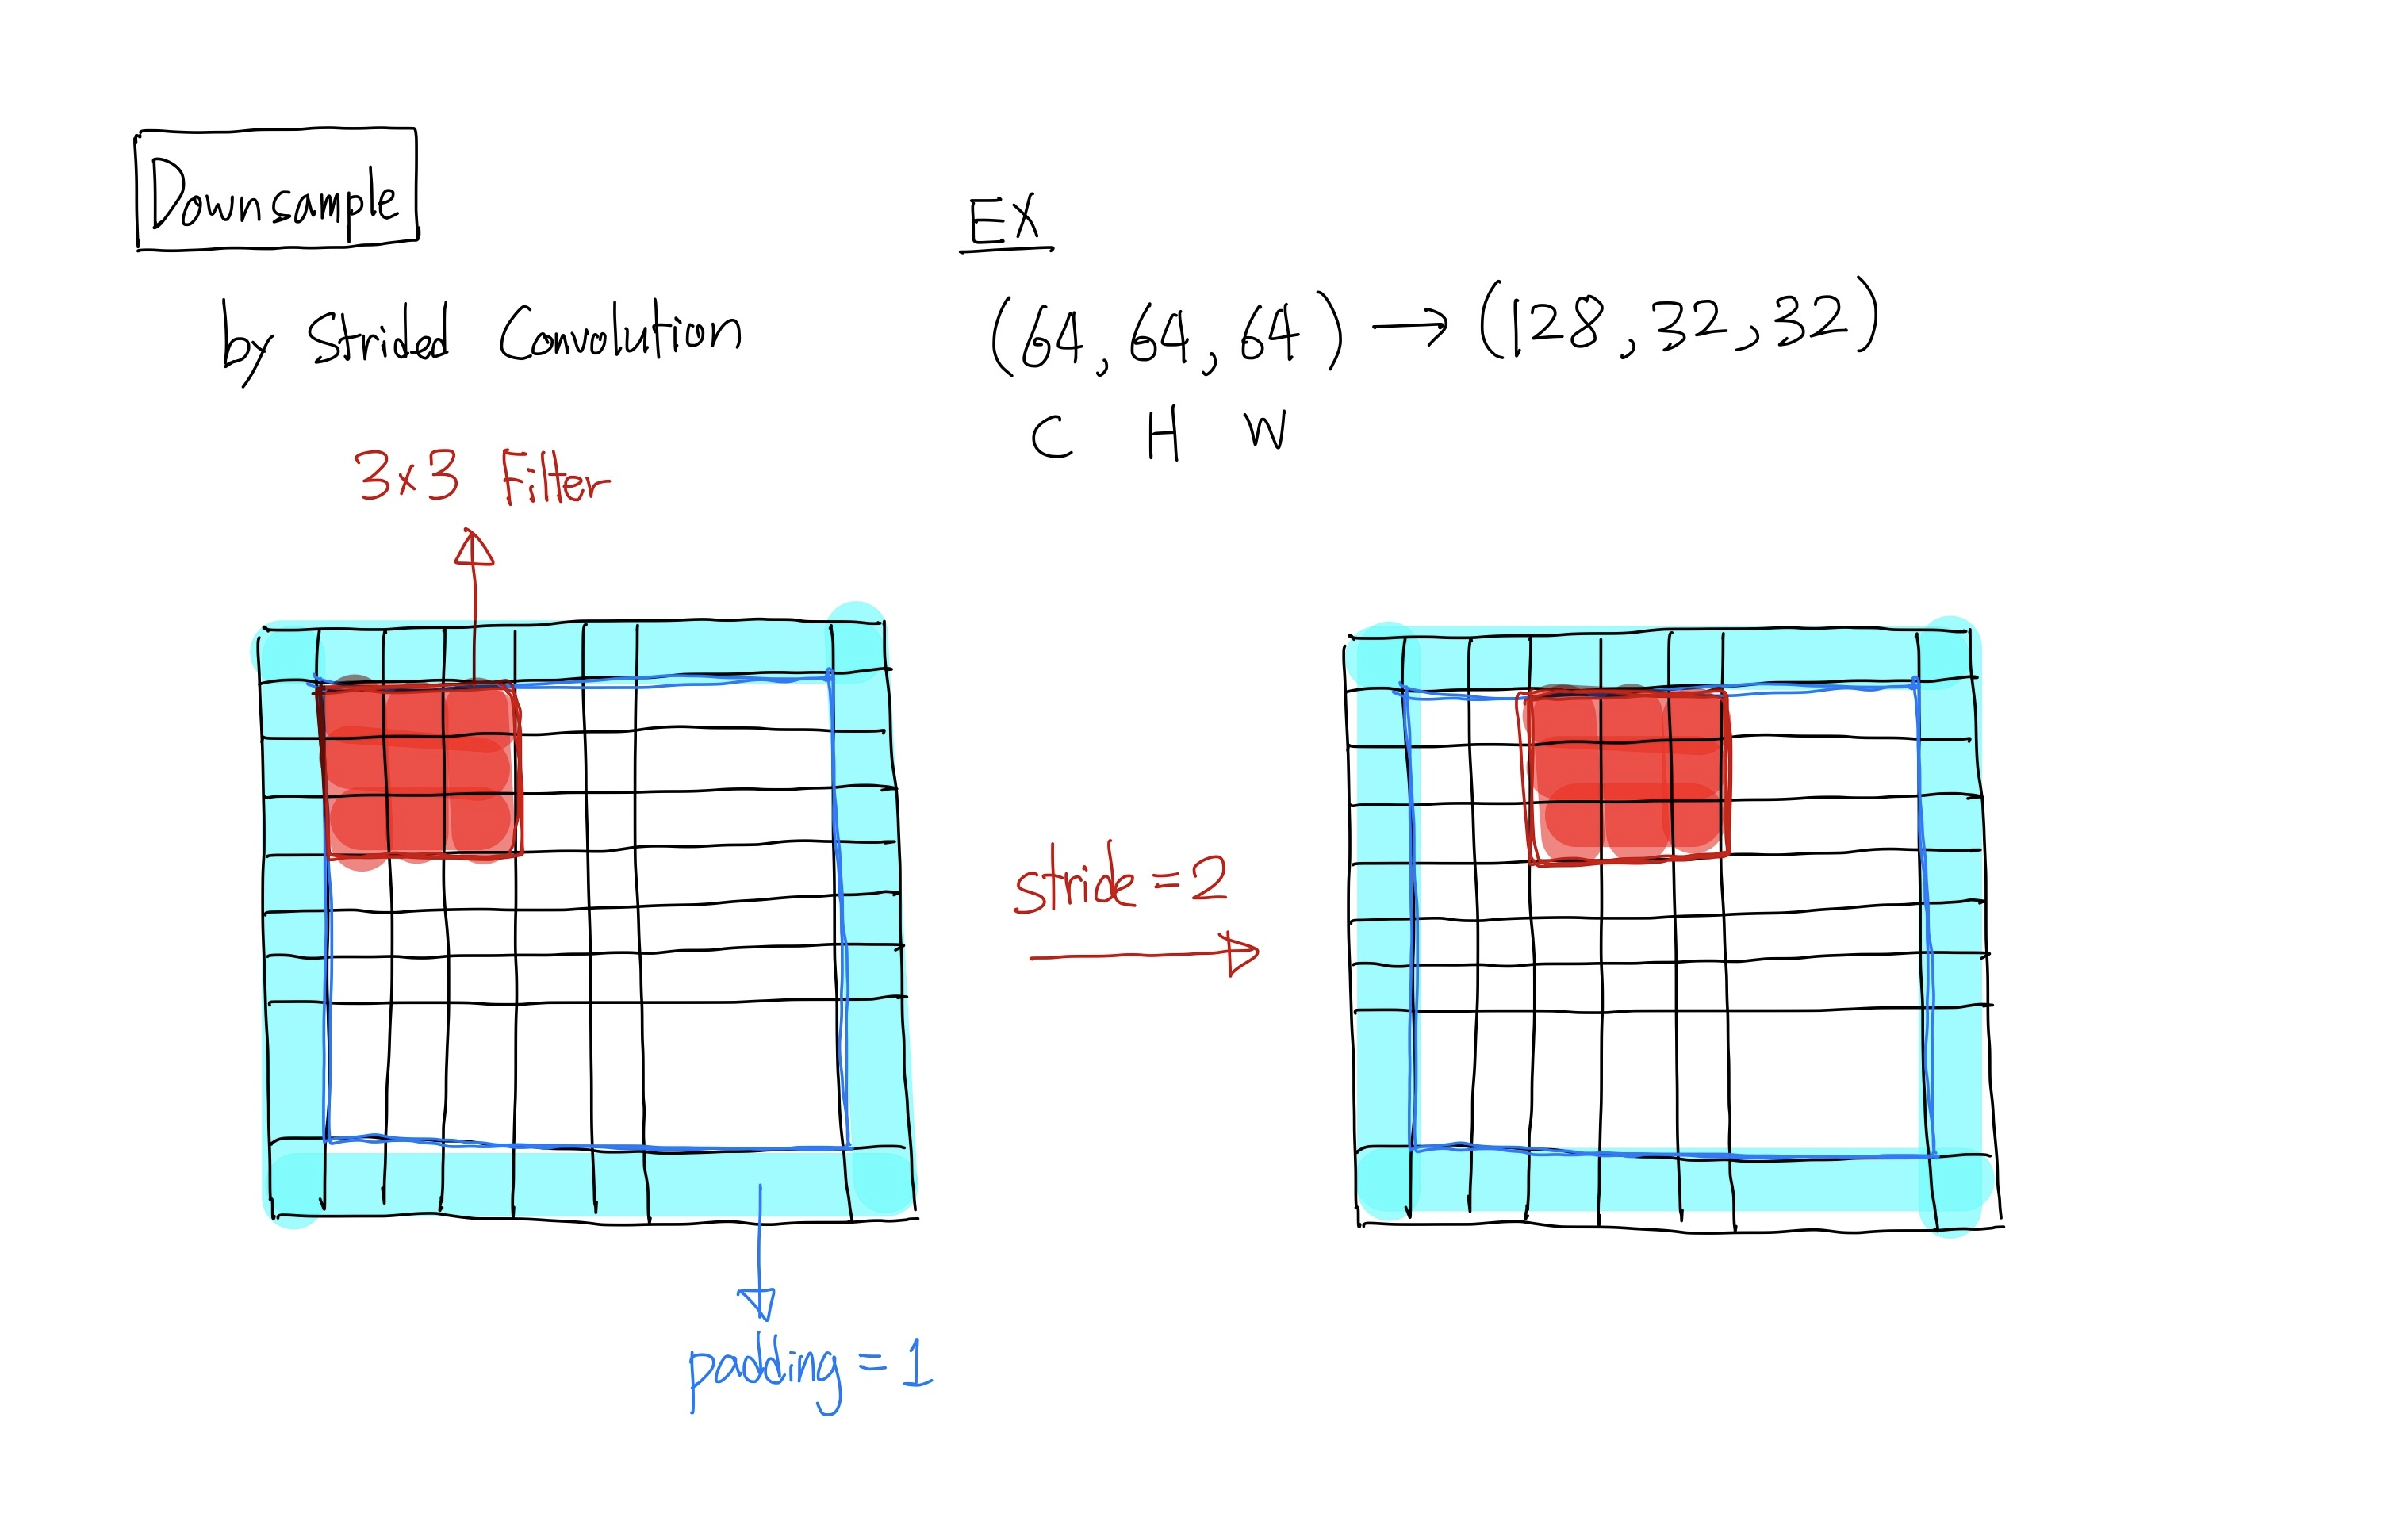